In [1]:

import numpy as np
from DeepQLearning.help_funcs import *
import matplotlib.pyplot as plt
import pandas as pd

### Initialization

We construct the transition probability matrix $M$ and the action space matrix $A$, where every row in $A$ represents an action (which is a weight vector attaching weights to each asset).

In [2]:

a = 5 # size of action space
A = np.random.dirichlet(np.full(a, 1), a)
# rows sums are 1
# every row represents an action

M = np.array([
    [0.95, 0.05, 0.00],
    [0.06, 0.91, 0.03],
    [0.00, 0.12, 0.88]
])

init_regime_prob_dist = [0.7, 0.15, 0.15]


Construct a regime sequence based on the transition probability matrix $M$

In [3]:

n = M.shape[0] # size of state space

V0 = np.full(a, 0.15)
S0 = np.full(a, 100)

T = 1000
T_test = 200

regime = np.random.choice(range(n), p=init_regime_prob_dist)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(range(n), p=M[regime, :])
    true_regimes_total[t] = next_regime
    regime = next_regime

print(true_regimes_total)

[1 1 1 ... 1 1 1]


Generate price and volatility data (synthetic data)

84
color green: low vol
color yellow: medium vol
color red: high vol


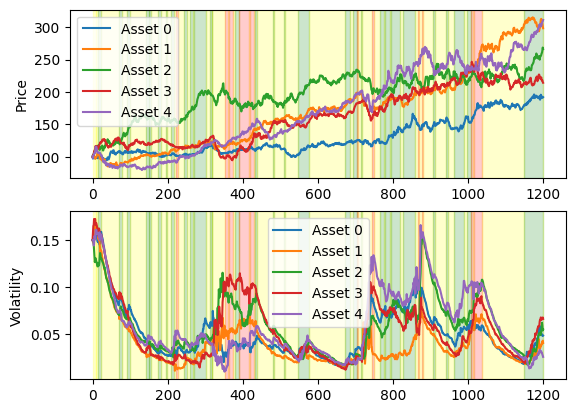

In [4]:
price_data_total = np.empty((T + T_test, a))
volatility_data_total = np.empty((T + T_test, a))

xi_values = [0.05, 0.2, 0.6] # volatility of volatility
kappa_values = [6, 1.0, 0.5] # mean reversion rate
theta_values = [0.01, 0.2, 1.2] # mean volatility
mu_values = [0.0, 1.0, -1.0] # price drift

V0 = np.full(a, 0.15)
S0 = np.full(a, 100)

price_data_total = np.empty((T + T_test, a))
volatility_data_total = np.empty((T + T_test, a))

fig, (ax1, ax2) = plt.subplots(2)

x_breakpoints = []
x_breakpoints_labels = []

t = 0
while t < T + T_test:
    this_regime = true_regimes_total[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes_total[tt] == this_regime:
            tt += 1
        else:
            break
    x_breakpoints.append(tt)
    x_breakpoints_labels.append(this_regime)
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0=V0[i],
                xi=xi_values[this_regime],
                theta=theta_values[this_regime],
                kappa=kappa_values[this_regime],
                N=tt - t,
                dt=1/365
            )
            for i in range(a)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(
            vola_values=volatility_data_total[t:tt, i],
            S0=S0[i],
            N=tt - t,
            mu=mu_values[this_regime],
            dt=1/365
    )
        for i in range(a)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

x_breakpoints_labels.append(this_regime)
x_breakpoints.append(t)

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(a):
    ax1.plot(range(T + T_test), price_data_total[:, i], label=f"Asset {i}")
    ax2.plot(range(T + T_test), volatility_data_total[:, i], label=f"Asset {i}")

ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

colors = ["green", "yellow", "red"]
color_labels = ["low vol", "medium vol", "high vol"]

for i in range(len(x_breakpoints) - 1):
    ax1.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)
    ax2.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

ax1.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)
ax2.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)

print(len(x_breakpoints_labels))

for c, cl in zip(colors, color_labels):
    print(f"color {c}: {cl}")

plt.show()

### Run the algorithm

In [43]:
# parameters
learning_rate = 0.1
discount_factor = 0.85
exp_eps_decay = 0.995 # multiply epsilon by this much every iteration
p = 30 # lookback period for sharpe ratio determination

eps = 1.0
Q = np.zeros((n, a))

W = np.empty((T, a))
state = 0

R = np.empty(T)
V = np.empty(T)

total_returns = pd.DataFrame(price_data_total).pct_change(axis=0).to_numpy()
observed_returns = total_returns[:T]
observed_returns[0, :] = np.zeros(a)
observed_volatility = np.empty((T, a))

# determine the thresholds for determining the regime (volatility based)
mean_returns = np.mean(observed_returns, axis=1)
vola = pd.Series(mean_returns).rolling(p, min_periods=1).std().values
vola[0] = 0
vola_thresholds = np.quantile(vola, [0.33, 0.67])

state_distribution = np.zeros(n)

def get_new_state(thresholds, new_val):
    c = 0
    for v in thresholds:
        if new_val <= v:
            return c
        c += 1
    return c

for t in range(T):

    if np.random.uniform() <= eps:
        # choose randomly
        action_chosen = np.random.randint(0, a)
    else:
        # pick best action
        action_chosen = np.argmax(Q[state, :])

    W[t, :] = A[action_chosen, :]
    R[t] = np.dot(W[t, :], observed_returns[t, :])
    observed_volatility[t, :] = np.std(observed_returns[max(0, t - p), :], axis=0)
    V[t] = np.std(R[max(0, t - p):t])
    sharpe = R[t] / max(0.01, V[t])

    next_state = get_new_state(vola_thresholds, V[t])
    state_distribution[next_state] += 1
    Q[state, action_chosen] = (
        (1 - learning_rate) * Q[state, action_chosen]
        +
        learning_rate * (sharpe + discount_factor * np.max(Q[next_state, :]))
    )
    eps *= exp_eps_decay
    state = next_state

C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Plot the cumulative returns and the volatility of the model

[       nan 0.         0.00526044 0.00474298 0.00859506 0.0091227
 0.00854023 0.00803419 0.00773898 0.00800645 0.00777054 0.00746448
 0.00752959 0.01016737 0.01007049 0.0097441  0.0094684  0.01095562
 0.01081537 0.01053816 0.010904   0.01145039 0.01127341 0.01125446
 0.01102856 0.01083082 0.01118915 0.01138598 0.01153688 0.01140016
 0.01120973 0.0116688  0.01150539 0.01149007 0.01136576 0.01162858
 0.01167953 0.0117152  0.01170314 0.01149037 0.01153296 0.01183771
 0.01290272 0.01218013 0.01204477 0.01218505 0.01244289 0.01140426
 0.01160153 0.01161781 0.01135946 0.0107025  0.01069987 0.01062669
 0.01075493 0.01081441 0.01038685 0.00992281 0.00962773 0.01005338
 0.01012266 0.00951663 0.00949033 0.00977545 0.00988754 0.00953814
 0.00945625 0.00946438 0.00962736 0.01022322 0.01024998 0.00991231
 0.00835523 0.0084859  0.00856783 0.00847639 0.00795166 0.00802204
 0.00790204 0.00790189 0.007925   0.00808571 0.00858099 0.00855047
 0.00865959 0.00866359 0.00866466 0.00909901 0.00916207 0.00903

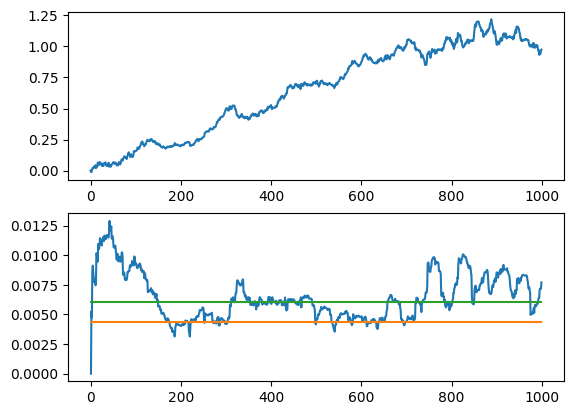

In [41]:
cum_returns = (1 + R).cumprod() - 1
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(cum_returns)
ax2.plot(V)
for h in vola_thresholds:
    ax2.plot(np.full(T, h))
print(V)
plt.show()

Plot the distributions of states for the trained model

[101. 397. 502.]


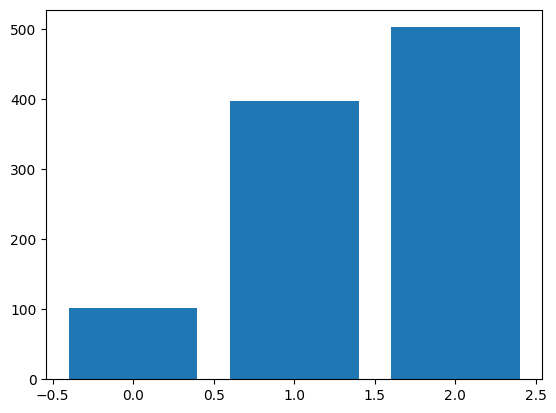

In [42]:
fig, ax = plt.subplots()
print(state_distribution)
ax.bar(x=range(3), height=state_distribution)
plt.show()

### Using the model for testing

We use the trained $Q$ table to generate actions for each timestep $t$, and store the generated return value (which is the dot product between the weight vector and the observed return vector) in $R$.

In [ ]:
observed_returns = total_returns[T:]
observed_returns[0, :] = np.zeros(a)
observed_volatility = np.empty((T_test, a))

W = np.empty((T_test, a))
state = state # set first state as last state of traning process

R = np.empty(T_test)
V = np.empty(T_test)

for t in range(T_test):
    
    action_chosen = np.argmax(Q[state, :])
    weights = A[action_chosen, :]
    next_state = get_new_state(vola_thresholds, V[t])
    state = next_state
    R[t] = np.dot(weights, observed_returns[t, :])
    V[t] = np.std(R[max(0, t - p):t])

C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


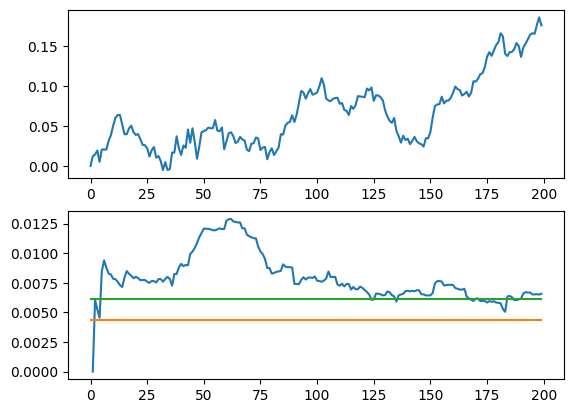

In [48]:
cum_returns = (1 + R).cumprod() - 1
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(cum_returns)
ax2.plot(V)
for h in vola_thresholds:
    ax2.plot(np.full(T_test, h))
plt.show()